# Project: Wrangling and Analyze Data

## Data Gathering
In the cells below, we will gather **all** three pieces of data for the project and load them in the notebook using different methods.

1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import tweepy
import numpy as np
import json
import time
import re

sns.set_theme(style="darkgrid")

In [2]:
twitter_archive = pd.read_csv('twitter_archive_enhanced.csv')
twitter_archive.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
177,857393404942143489,NaN,NaN,2017-04-27 00:38:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Instead of the usual nightly dog rate, I'm sha...",NaN,NaN,NaN,https://www.gofundme.com/meeko-needs-heart-sur...,13,10,None,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
filename = 'image_predictions.tsv'

In [4]:
response = requests.get(url)
with open(filename, 'wb') as file:
    file.write(response.content)

In [5]:
image_predictions = pd.read_csv(filename, sep='\t')
image_predictions.sample()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1397,768193404517830656,https://pbs.twimg.com/media/Cqkr0wiW8AAn2Oi.jpg,1,lion,0.396984,False,ram,0.300851,False,cheetah,0.094474,False


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [6]:
credentials = {}
attributes = ['id_str', 'retweet_count', 'favorite_count', 'created_at', 'in_reply_to_status_id_str']
keys = ['key', 'secret', 'token', 'token_secret']
with open('credentials.txt') as file:
    for k in keys:
        credentials[k] = file.readline()[:-1]

In [7]:
# Creating the list of tweet IDs
tweet_ids = np.unique(list(twitter_archive.tweet_id.unique()) + list(image_predictions.tweet_id.unique()))

In [8]:
auth = tweepy.OAuth1UserHandler(credentials['key'], credentials['secret'])
auth.set_access_token(credentials['token'], credentials['token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True)

In [9]:
def read_tweets(tweet_ids):
    datas = []
    errors = []
    count = 0
    limit = len(tweet_ids)
    print('Starting the collect...')
    for tweet_id in tweet_ids:
        count += 1
        if count > limit:
            break
        try:
            start = time.time()
            tweet = api.get_status(tweet_id)
            datas.append({a : tweet._json[a] for a in attributes})
            end = time.time()
            print(f'{count}/{limit} - Tweet id {tweet_id} retrieved after {end - start:.1f} seconds')
        except Exception as e:
            errors.append({'tweet_id': tweet_id, 'error': str(e)})
            print(f'{count} - Error retrieving tweet : {tweet_id}')
    print('... Collect ended')
    return datas, errors

In [10]:
datas, errors = read_tweets(tweet_ids)
if errors:
    d, e = read_tweets([t['tweet_id'] for t in errors])
    datas += d

# Storing data in tweet_json.txt
with open('tweet_json.txt', 'w') as file:
    for data in datas:
        file.write(json.dumps(data) + '\n')

In [11]:
# Reading the file and creating the Dataframe
datas = []
with open('tweet_json.txt') as file:
    for line in file:
        datas.append(json.loads(line))
tweet_metrics = pd.json_normalize(datas)
tweet_metrics.sample()

,id_str,retweet_count,favorite_count,created_at,in_reply_to_status_id_str
49,666835007768551424,65,183,Wed Nov 18 04:27:09 +0000 2015,None


## Assessing Data
In this section, we will detect and document at least **eight (8) quality issues and two (2) tidiness issue** using **both** visual assessment and programmatic assessement to assess the data.

### Visual evaluations

In [12]:
# Visual evaluation of twitter_archive
twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
163,860276583193509888,NaN,NaN,2017-05-04 23:34:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jordy. He likes to go on adventures an...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/860276583...,12,10,Jordy,None,None,None,None
1260,710269109699739648,NaN,NaN,2016-03-17 00:58:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The squad is back for St. Patrick's Day! ☘ 💚\n...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710269109...,13,10,None,None,None,None,None
1163,723673163800948736,NaN,NaN,2016-04-23 00:41:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ivar. She is a badass Viking warrior. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/723673163...,10,10,Ivar,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
2079,670826280409919488,NaN,NaN,2015-11-29 04:47:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Scary dog here. Too many legs. Extra tail. Not...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670826280...,2,10,None,None,None,None,None
827,769212283578875904,NaN,NaN,2016-08-26 16:37:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is DonDon. He's way up but doesn't feel b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/769212283...,12,10,DonDon,None,None,None,None
913,757400162377592832,NaN,NaN,2016-07-25 02:20:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",She walks herself up and down the train to be ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/757400162...,13,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
807,771908950375665664,NaN,NaN,2016-09-03 03:13:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Doggo will persevere. 13/10\nhttps://t.co/yOVz...,NaN,NaN,NaN,https://twitter.com/yahoonews/status/771905568...,13,10,None,doggo,None,None,None
1724,680085611152338944,NaN,NaN,2015-12-24 18:00:19 +0000,"<a href=""https://about.twitter.com/products/tw...",This is by far the most coordinated series of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680085611...,12,10,by,None,None,None,None


In [13]:
# Visual evaluation of image_predictions
image_predictions.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
538,676949632774234114,https://pbs.twimg.com/media/CWUCGMtWEAAjXnS.jpg,1,Welsh_springer_spaniel,0.206479,True,Saint_Bernard,0.139339,True,boxer,0.114606,True
1698,816816676327063552,https://pbs.twimg.com/media/C1XqbhXXUAElpfI.jpg,1,malamute,0.668164,True,Pembroke,0.105033,True,Siberian_husky,0.077875,True
836,694206574471057408,https://pbs.twimg.com/media/CaJRMPQWIAA1zL9.jpg,1,Shih-Tzu,0.352547,True,toy_poodle,0.155720,True,Maltese_dog,0.116657,True
2067,890729181411237888,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
890,699323444782047232,https://pbs.twimg.com/media/CbR-9edXIAEHJKi.jpg,1,Labrador_retriever,0.309696,True,doormat,0.303700,False,sliding_door,0.077266,False
339,672245253877968896,https://pbs.twimg.com/media/CVRLfeoW4AA_ldZ.jpg,1,Chihuahua,0.718944,True,badger,0.178546,False,toy_terrier,0.037103,True
1458,777885040357281792,https://pbs.twimg.com/media/CsuaUH2WAAAWJh1.jpg,1,Afghan_hound,0.123529,True,basset,0.119682,True,Siberian_husky,0.108709,True
1129,728015554473250816,https://pbs.twimg.com/media/ChpuRyvVAAARMoq.jpg,1,cocker_spaniel,0.384559,True,golden_retriever,0.091661,True,sandbar,0.081799,False
1786,829449946868879360,https://pbs.twimg.com/media/C4LMUf8WYAkWz4I.jpg,1,Labrador_retriever,0.315163,True,golden_retriever,0.153210,True,Pekinese,0.132791,True
1172,736736130620620800,https://pbs.twimg.com/media/CjlpmZaUgAED54W.jpg,1,schipperke,0.545502,True,groenendael,0.298622,True,Labrador_retriever,0.030986,True


### Programmatic evaluations

In [14]:
# Programmatic evaluation of `twitter_archive`
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [15]:
twitter_archive.rating_numerator.describe()

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [16]:
# Explore the line with a 0 for numerator
twitter_archive.query('rating_numerator == 0')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459...,0,10,None,None,None,None,None


In [17]:
twitter_archive.rating_denominator.describe()

count    2356.000000
mean       10.455433
std         6.745237
min         0.000000
25%        10.000000
50%        10.000000
75%        10.000000
max       170.000000
Name: rating_denominator, dtype: float64

In [18]:
# Distinct values of rating_denominator
twitter_archive.rating_denominator.unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2])

In [19]:
# Explore the lines with denominator == 0
twitter_archive.query('rating_denominator == 0')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


In [20]:
# Looking for duplicated values
twitter_archive.duplicated().sum()

0

No duplicated lines found in the table `twitter_archive`

In [21]:
# Looking for duplicated tweet_id
twitter_archive.tweet_id.duplicated().sum()

0

No duplicated `tweet_id` found in the table `twitter_archive`

In [22]:
# Programmatic evaluation of `image_predictions`
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [23]:
# Looking for duplicated values
image_predictions.duplicated().sum()

0

No duplicated values in the table `image_predictions`

In [24]:
# Programmatic evaluation of `tweet_metrics`
tweet_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id_str                     2327 non-null   object
 1   retweet_count              2327 non-null   int64 
 2   favorite_count             2327 non-null   int64 
 3   created_at                 2327 non-null   object
 4   in_reply_to_status_id_str  77 non-null     object
dtypes: int64(2), object(3)
memory usage: 91.0+ KB


### Quality issues

1. Missing data in columns `name`, `doggo`, `floofer`, `pupper` and `puppo` using the text `'None'` instead of `NaN`

1. Dogs with `name` __"a", "by", "an", "getting"__ in column `twitter_archives.name`

1. `expanded_url` in datatable `twitter_archives` containts repeated urls on a single line and also links from accounts other than __@dog_rates__

1. Missing data in `expanded_url` in datatable `twitter_archives`

1. Invalid dog rating in columns `rating_numerator` and `rating_denominator` read from the text of some tweets

1. Agregated rating for pictures having more than 1 dog in it (204/170, 45/50, ...), not all ratings are done __/10__

1. Invalid rating : some tweets have a `rating_denominator` which is not a multiple of 10, others have `0` as `rating_numerator` or `rating_denominator`

1. Invalid data type for column `timestamp` and `retweeted_status_timestamp` of `twitter_archives` and `id_str` of `tweet_metrics`

1. Inconsistent columns names between datatables : `created_at`, `id_str`, `in_reply_to_status_id_str` of `tweet_metrics`

1. Missing data in table `image_predictions` : 2075 instead of 2356

1. Some rows are only retweets or replies to existing rating tweets and others are not related to dog rating at all

1. Missing dog species in `twitter_archive` table

### Tidiness issues
1. Dog stage information (1 variable) spread over 4 columns `doggo`, `floofer`, `pupper` and `puppo` in datatable `twitter_archives`

2. Dog race and tweet counts located in separate tables

## Cleaning Data
In this section, we will clean **all** of the issues documented while assessing.

In [25]:
# Make copies of original pieces of data
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
tweet_metrics_clean = tweet_metrics.copy()

### Data type issues
- Invalid data type for column `timestamp` and `retweeted_status_timestamp` of `twitter_archives` and `id_str` of `tweet_metrics`

Columns containing date values is of type `object` instead of `datetime`.
The `id_str` column extracted from json data is of type `str` instead of `int64`

#### Define
##### `twitter_archive` table
- Change `timestamp` and `retweeted_status_timestamp` data type from `object` to `datetime`

##### `tweet_metrics` table
- Change `id_str` data type from `str` to `int64`

#### Code

In [26]:
# twitter_archive table
twitter_archive_clean.timestamp = twitter_archive_clean.timestamp.astype('datetime64[ns]')
twitter_archive_clean.retweeted_status_timestamp = twitter_archive_clean.retweeted_status_timestamp.astype('datetime64[ns]')

# tweet_metrics table
tweet_metrics_clean.id_str = tweet_metrics_clean.id_str.astype('int64')

#### Test

In [27]:
twitter_archive_clean.timestamp.dtypes

dtype('<M8[ns]')

In [28]:
twitter_archive_clean.retweeted_status_timestamp.dtypes

dtype('<M8[ns]')

In [29]:
tweet_metrics_clean.id_str.dtypes

dtype('int64')

### Column name issues
- Inconsistent columns names between datatables : `created_at`, `id_str`, `in_reply_to_status_id_str` of `tweet_metrics`

#### Define
- Rename column in `tweet_metrics` for consistency `{'created_at': 'timestamp', 'id_str': 'tweet_id', 'in_reply_to_status_id_str': 'in_replay_to_status_id'}`

#### Code

In [30]:
tweet_metrics_clean.rename(columns={'created_at': 'timestamp',
                                    'id_str': 'tweet_id',
                                    'in_reply_to_status_id_str': 'in_reply_to_status_id'}, inplace=True)

#### Test

In [31]:
tweet_metrics_clean.columns

Index(['tweet_id', 'retweet_count', 'favorite_count', 'timestamp',
       'in_reply_to_status_id'],
      dtype='object')

### Issues with retweets
- Some rows are only retweets or replies to existing rating tweets and others are not related to dog rating at all

The rows that are retweets either repeat themselves with their original tweet which is also present in our Dataset or are retweets from tweet originaly made by other accounts (other than @dog_rates). The same issue is observed for lines that are replies to other tweets

#### Define
- Filter `twitter_archive` and extract all lines having `retweeted_status_id` and `in_reply_to_status_id` set to `null`

#### Code

In [32]:
twitter_archive_clean = twitter_archive_clean.query('in_reply_to_status_id != in_reply_to_status_id and retweeted_status_id != retweeted_status_id')


#### Test

In [33]:
assert len(twitter_archive_clean.query('in_reply_to_status_id > 0 and retweeted_status_id > 0')) == 0

### `expanded_urls` column issues
- `expanded_url` in datatable `twitter_archive` containts repeated urls on a single line and also links from accounts other than __@dog_rates__
- Missing data in `expanded_url` in datatable `twitter_archive`

Some lines contain multiple values in the `expanded_url` column separated by a comma. Some of those values repeat themselves and others does not correspond to tweets made by __@dog_rates__.
Some lines are just empty in that column

#### Define
- Split the values in `expanded_url` using the comma as separator and only keep the first value containing __dog_rates__ in its text.
- Unfortunately, there is nothing we can do for missing expanded_urls

#### Code

In [34]:
def clean_expanded_url(expanded_url):
    clean_url = None
    if not pd.isnull(expanded_url):
        for url in expanded_url.split(','):
            if 'dog_rates' in url:
                clean_url = url.strip()
                break
    return clean_url

In [35]:
twitter_archive_clean.expanded_urls = twitter_archive_clean.expanded_urls.apply(clean_expanded_url)

#### Test

In [36]:
assert twitter_archive_clean.expanded_urls.str.contains(',').sum() == 0

### Invalid ratings
- Invalid dog rating in columns `rating_numerator` and `rating_denominator` read from the text of some tweets

- Agregated rating for pictures having more than 1 dog in it (204/170, 45/50, ...), not all ratings are done __/10__

- Invalid rating : some tweets have a `rating_denominator` which is not a multiple of 10, others have `0` as `rating_numerator` or `rating_denominator`

There was probably an error while extracting the ratings from the text since the algorithm only considered the first appearance of any couple of numbers in the format x/y although on some posts, the rating is further away. The algorithm sometimes mistakes a date to a rating.

On some lines we noticed via visual observation that images having many dogs usually have a rating which is `n*(x/10)` where `n` is the number of dogs and `x/10` is a valid rating.

There are some rows where the numerator is 0 or the denominator is 0. They correspond to posts where either there is no dog thus no valid rating or it's a valid post but with a stolen picture making them invalid.

#### Define

- Extract the rating for a second time on all lines in the `text` column by considering the latest couple of numbers in the format __x/y__ in the `text` using the __python regex__ function `re.findall()[-1]` with the pattern `(\d+)/(\d+)` to extract both `rating_numerator` and `rating_denominator` at the same time
- For `rating_denominator` that are not multiple of 10, set `rating_denominator` to the value `0`
- For `rating_denominator` with value >10 that are multiple of 10, replace `rating_numerator` using the formula `rating_numerator = 10 * rating_numerator / rating_denominator` and set `rating_denominator` to the value `10` 
- Delete all lines with either `rating_numerator == 0` or `rating_denominator == 0`

#### Code

In [37]:
def fix_rating(df):
    num, den = re.findall('(\d+)/(\d+)', df.text)[-1]
    num, den = int(num), int(den)
    if (den % 10) != 0:
        den = 0
    elif den > 0:
        num = int(10 * num / den)
        den = 10
    df.rating_numerator = num
    df.rating_denominator = den
    return df

In [38]:
twitter_archive_clean = twitter_archive_clean.apply(fix_rating, axis = 1)

# Delete all lines where rating_numerator == 0 or rating_denominator == 0
twitter_archive_clean = twitter_archive_clean.query('rating_numerator != 0 and rating_denominator != 0')

#### Test

In [39]:
assert len(twitter_archive_clean.query('rating_numerator == 0 or rating_denominator == 0')) == 0
assert len(twitter_archive_clean.query('rating_denominator != 10')) == 0

### Issues with dog name
- Dogs with `name` __"a", "by", "an", "getting"__ in column `twitter_archives.name`
- Missing dog name using the text `'None'` instead of `NaN`

The name of dogs where probably extracted automatically from the `text` column and some times the algorithm failed to detect the name and just return __"a"__ or __"by"__ or __"an"__ or __"getting"__ as value.

#### Define
- Transform the `text` to lowercase with `str.lower()` then extract dog name (at least 2 characters to eliminate `a` as value) from text using __python regex__ with the following patterns :
    - `'this is ([a-zA-Z]{2,})'`
    - `'name is ([a-zA-Z]{2,})'`
    - `'meet ([a-zA-Z]{2,})'`
    - `'hello to ([a-zA-Z]{2,})'`
    - `'named ([a-zA-Z]{2,})'`
- Each time a pattern is tested, if the extracted name is not valid (empty or equal to `an` or `by` or `getting`) then apply the next pattern.
- At the end, if all the patterns failed, return `NaN`
- Capitalize the name before returning it with `str.capitalize()`

#### Code

In [40]:
def extract_name(text):
    patterns = ['this is ([a-zA-Z]{2,})',
                'name is ([a-zA-Z]{2,})',
                'meet ([a-zA-Z]{2,})',
                'hello to ([a-zA-Z]{2,})',
                'named ([a-zA-Z]{2,})']
    for p in patterns:
        name = re.search(p, text.lower())
        if name:
            name = name[1]
            if name in ['an', 'by', 'getting']:
                continue
            return name.capitalize()
    return None

In [41]:
twitter_archive_clean.name = twitter_archive_clean.text.apply(extract_name)

#### Test

In [42]:
assert len(twitter_archive_clean.query('name in ["a", "an", "by", "getting"]')) == 0

### Issue with dog stage

- Missing data in columns `doggo`, `floofer`, `pupper` and `puppo` using the text `None` instead of `NaN`
- Dog stage information (1 variable) spread over 4 columns `doggo`, `floofer`, `pupper` and `puppo` in datatable `twitter_archive`

The four stages of a dog are `pupper` -> `puppo` -> `doggo` -> `floofer` in that order. The information presented in the dataset is not tidy.

#### Define

- Create a new column `stage` containing the name of the dog stage (`pupper`, `puppo`, `doggo` or `floofer`) depending on the four columns mentionned above by considering the first stage encountered in the reverse order :
    - If `floofer` is mentionned then set the value to `'floofer'`, else
    - If `doggo` is mentionned then set the value to `'doggo'`, else
    - If `puppo` is mentionned then set the value to `'puppo'`, else
    - If `pupper` is mentionned then set th evalue to `'pupper'`.
- If none of the four columns has a valid value, set `stage` to `NaN`
- Drop all four unnecessary columns with `pandas` `.drop()` function

#### Code

In [43]:
def extract_stage(df):
    if df.floofer == 'floofer':
        return 'floofer'
    if df.doggo == 'doggo':
        return 'doggo'
    if df.puppo == 'puppo':
        return 'puppo'
    if df.pupper == 'pupper':
        return 'pupper'
    return None

In [44]:
twitter_archive_clean['stage'] = twitter_archive_clean.apply(extract_stage, axis=1)
twitter_archive_clean.drop(columns=['pupper', 'doggo', 'puppo', 'floofer'], inplace=True)

#### Test

In [45]:
twitter_archive_clean.stage.unique()

array([None, 'doggo', 'puppo', 'pupper', 'floofer'], dtype=object)

In [46]:
twitter_archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'stage'],
      dtype='object')

### Missing image prediction and data in different tables

- Missing data in table `image_predictions` : 2075 instead of 2356
- Dog race and tweet counts located in separate tables

We don't have all information on dog image prediction, we will only consider the data already collected in `image_predictions` table

#### Define

- Perform an inner merge between tables `twitter_archive` and `image_prediction` using the column `tweet_id`
- Perform an inner merge between tables `twitter_archive` and `tweeter_metrics` using the column `tweet_id`
- Drop unnecessary columns

#### Code

In [47]:
merged = twitter_archive_clean.merge(image_predictions_clean, how='inner', on='tweet_id')
twitter_archive_clean = merged.merge(tweet_metrics_clean[['tweet_id', 'retweet_count', 'favorite_count']], how='inner', on='tweet_id')


In [48]:
drop_columns = ['in_reply_to_status_id', 'in_reply_to_user_id', 'source',
                'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp',
                'jpg_url', 'img_num']
twitter_archive_clean.drop(columns=drop_columns, inplace=True)

#### Test

In [49]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1961 entries, 0 to 1960
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1961 non-null   int64         
 1   timestamp           1961 non-null   datetime64[ns]
 2   text                1961 non-null   object        
 3   expanded_urls       1961 non-null   object        
 4   rating_numerator    1961 non-null   int64         
 5   rating_denominator  1961 non-null   int64         
 6   name                1403 non-null   object        
 7   stage               302 non-null    object        
 8   p1                  1961 non-null   object        
 9   p1_conf             1961 non-null   float64       
 10  p1_dog              1961 non-null   bool          
 11  p2                  1961 non-null   object        
 12  p2_conf             1961 non-null   float64       
 13  p2_dog              1961 non-null   bool        

### Missing dog species

- Missing dog species in `twitter_archive` table

#### Define
- Create a new column named `species` containing the dog specie with the best prediction and for which `px_dog` is `True`
- Drop unnecessary columns

#### Code

In [50]:
def extract_species(df):
    species = None
    conf = 0.0
    if df.p1_dog:
        conf = df.p1_conf
        species = df.p1
    elif df.p2_dog:
        if df.p2_conf > conf:
            conf = df.p2_conf
            species = df.p2
    elif df.p3_dog:
        if df.p3_conf > conf:
            species = df.p3
    if species:
        return species.replace('_', ' ').capitalize()
    return None

In [51]:
twitter_archive_clean['species'] = twitter_archive_clean.apply(extract_species, axis=1)
drop_columns = ['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']
twitter_archive_clean.drop(columns = drop_columns, inplace=True)

#### Test

In [52]:
twitter_archive_clean.sample(5)

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,species
35,884562892145688576,2017-07-11 00:00:02,This is Kevin. He's just so happy. 13/10 what ...,https://twitter.com/dog_rates/status/884562892...,13,10,Kevin,None,3898,21267,Pug
1599,672898206762672129,2015-12-04 22:00:08,This is Cheryl AKA Queen Pupper of the Skies. ...,https://twitter.com/dog_rates/status/672898206...,11,10,Cheryl,pupper,363,794,None
366,813066809284972545,2016-12-25 17:00:08,This is Tyr. He is disgusted by holiday traffi...,https://twitter.com/dog_rates/status/813066809...,12,10,Tyr,None,1822,7532,Toy terrier
443,794926597468000259,2016-11-05 15:37:24,This is Mack. He's rather h*ckin sleepy. Excep...,https://twitter.com/dog_rates/status/794926597...,12,10,Mack,None,2153,9658,Toy poodle
1159,692752401762250755,2016-01-28 16:53:37,"""Hello yes could I get one pupper to go please...",https://twitter.com/dog_rates/status/692752401...,13,10,None,pupper,3296,6276,Samoyed


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [53]:
twitter_archive_clean.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, we will analyze and visualize our wrangled data. We will produce at least **three (3) insights and one (1) visualization.**

In [54]:
twitter_archive_master = pd.read_csv('twitter_archive_master.csv')
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1961 entries, 0 to 1960
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            1961 non-null   int64 
 1   timestamp           1961 non-null   object
 2   text                1961 non-null   object
 3   expanded_urls       1961 non-null   object
 4   rating_numerator    1961 non-null   int64 
 5   rating_denominator  1961 non-null   int64 
 6   name                1403 non-null   object
 7   stage               302 non-null    object
 8   retweet_count       1961 non-null   int64 
 9   favorite_count      1961 non-null   int64 
 10  species             1656 non-null   object
dtypes: int64(5), object(6)
memory usage: 168.6+ KB


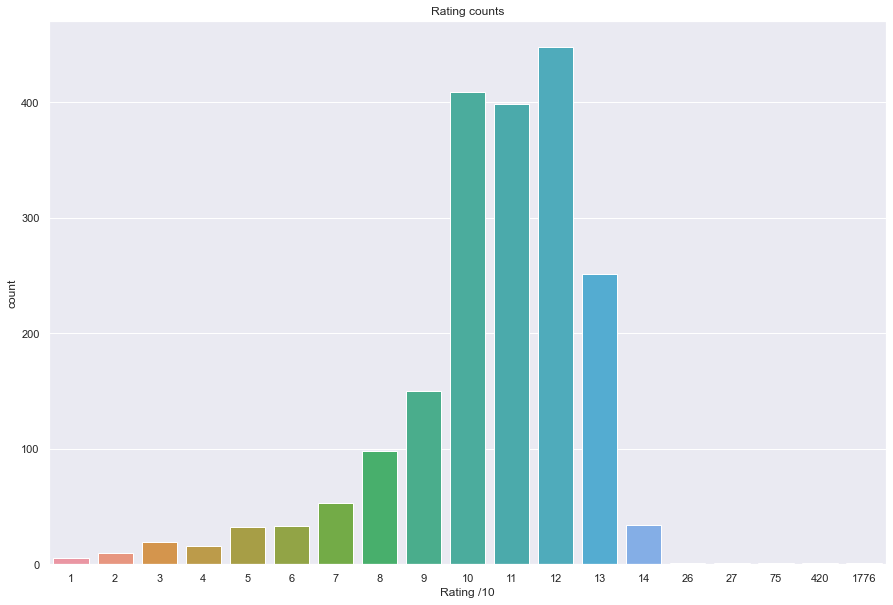

In [55]:
plt.figure(figsize=(15, 10))
sns.countplot(x='rating_numerator', data=twitter_archive_master)
plt.title('Rating counts')
plt.xlabel('Rating /10')
plt.show()

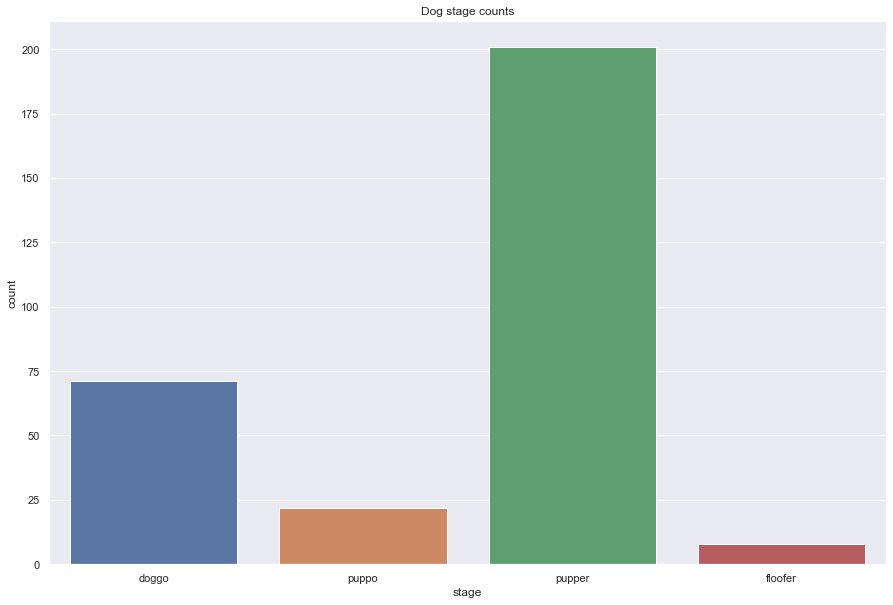

In [56]:
plt.figure(figsize=(15, 10))
sns.countplot(x='stage', data=twitter_archive_master)
plt.title('Dog stage counts')
plt.show()

In [57]:
twitter_archive_master.species.value_counts()

Golden retriever        155
Labrador retriever      103
Pembroke                 94
Chihuahua                90
Pug                      62
                       ... 
Entlebucher               1
Clumber                   1
Standard schnauzer        1
Bouvier des flandres      1
Japanese spaniel          1
Name: species, Length: 113, dtype: int64

In [58]:
twitter_archive_master.groupby('stage').favorite_count.sum()

stage
doggo      1231585
floofer      93153
pupper     1253041
puppo       429536
Name: favorite_count, dtype: int64

### Insights:
1. The most represented ratings in our dataset are **10**, **11** and **12**. The majority of dogs were real _**good boys**_ with a rating above 10/10

1. Most of the rated pictures are of dogs at the **pupper** stage

1. The 04 most represented species are **Golder retrievers**, **Labrador retriever**, **Pembroke** and **Chihuahua**

1. Post receiving the most likes are of dogs at **doggo** or **pupper** stages

### Visualization

- Relationship between dog species and tweet favorites

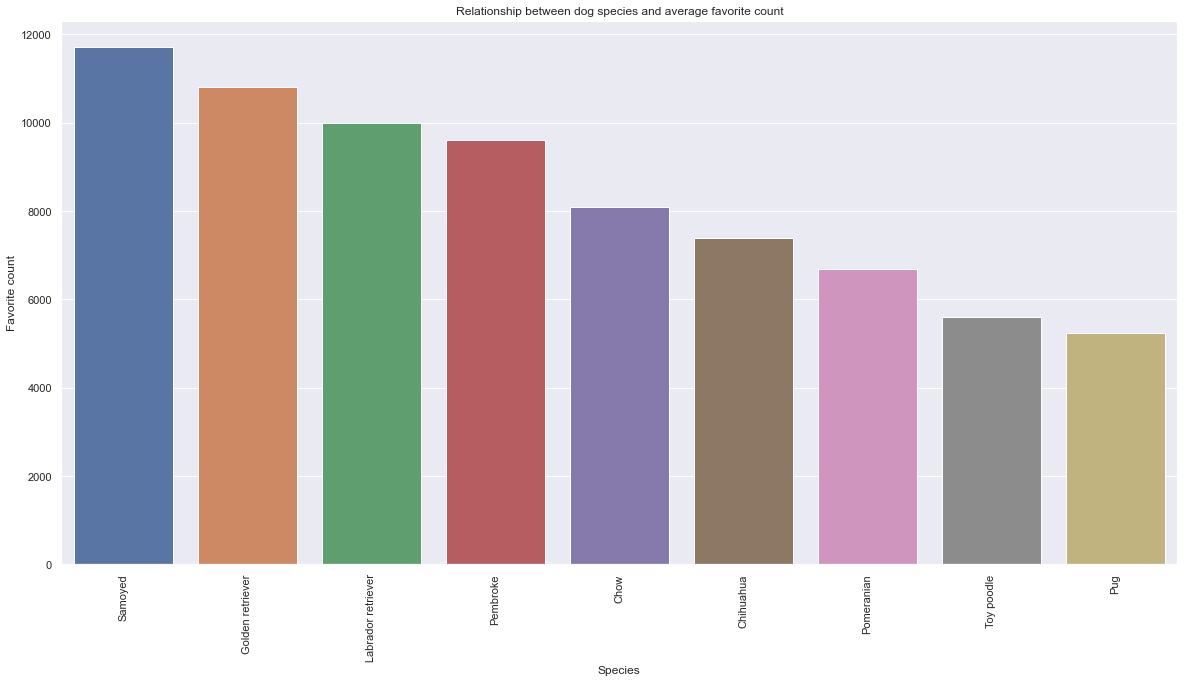

In [59]:
species = list(twitter_archive_master.species.value_counts()[twitter_archive_master.species.value_counts() > 40].index)
df = twitter_archive_master.query(f'species in {species}')
df = df.groupby('species', as_index=False).mean().sort_values(by='favorite_count', ascending=False)

plt.figure(figsize=(20, 10))
sns.barplot(x=df.species, y=df.favorite_count)
plt.xticks(rotation='vertical')
plt.xlabel('Species')
plt.ylabel('Favorite count')
plt.title('Relationship between dog species and average favorite count')
plt.show()

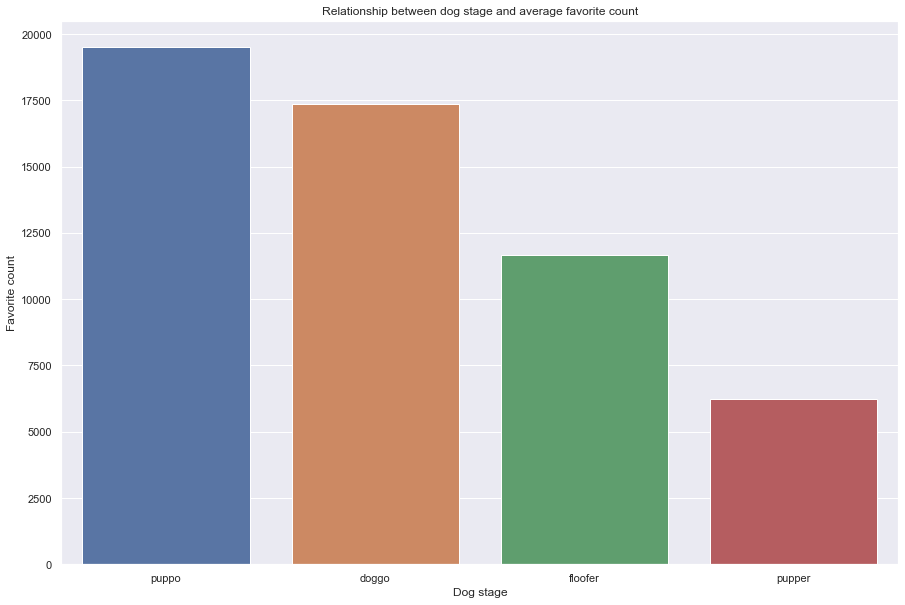

In [60]:
df = twitter_archive_master.groupby('stage', as_index=False).mean().sort_values(by='favorite_count', ascending=False)
plt.figure(figsize=(15, 10))
sns.barplot(x=df.stage, y=df.favorite_count)
plt.xlabel('Dog stage')
plt.ylabel('Favorite count')
plt.title('Relationship between dog stage and average favorite count')
plt.show()